In [69]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import xgboost
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.insert(0, '../dataset/')
import store_sales

In [2]:
store_sales.generate_store_sales_data(nStores=200,nDays=1000,filename='store_sales.csv')

Done generating store sales data


In [71]:
def preprocess_data():
    df = pd.read_csv('store_sales.csv')
    df['weekday'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())
    df['store_id'] = LabelEncoder.fit_transform(df['store_name'],df['store_name'])
    df['month'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').month)
    df['epoch_day'] = df['date'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%d')-datetime(2015,5,13)).days)
    df['epoch_month'] = df['date'].apply(lambda x: int((datetime.strptime(x,'%Y-%m-%d')-datetime(2015,5,13)).days/30))
    df.to_csv('store_sales_mod.csv',index=False)
preprocess_data()

In [29]:
%matplotlib notebook
def train_with_learning_curve(dtrain,dval,param,num_rounds):
    fig = plt.figure()
    axis = fig.add_subplot(111)
    axis.set_xlim(right=num_rounds)
    evals = [(dtrain,'train'),(dval,'val')]
    evals_result={}
    train_error=[]
    val_error=[]
    bst = None
    for i in range(num_rounds):
        bst = xgboost.train(param,dtrain,1,evals=evals,evals_result=evals_result,
                       verbose_eval=False)
        ptrain = bst.predict(dtrain,output_margin=True)
        pval = bst.predict(dval,output_margin=True)
        dtrain.set_base_margin(ptrain)
        dval.set_base_margin(pval)
        train_error.append(evals_result['train']['rmse'][0])
        val_error.append(evals_result['val']['rmse'][0])
        axis.clear()
        axis.plot(np.arange(len(train_error)),train_error)
        axis.plot(np.arange(len(val_error)),val_error)
        fig.canvas.draw()
    print(evals_result)
    print(dtrain)
    print(dval)
    return bst

In [65]:
df = pd.read_csv('store_sales_mod.csv')
df = df[df.store_id==1]
df = df.sort_values('date')
df.head()

,store_name,date,sales,weekday,store_id,month,epoch_day
9000,Store_10,2015-05-13,440.86,2,1,5,5611
9001,Store_10,2015-05-14,481.38,3,1,5,5612
9002,Store_10,2015-05-15,480.15,4,1,5,5613
9003,Store_10,2015-05-16,431.67,5,1,5,5614
9004,Store_10,2015-05-17,441.55,6,1,5,5615


['store_id_135', 'epoch_month_11', 'store_id_49', 'store_id_94', 'store_id_65', 'store_id_23', 'store_id_56', 'store_id_129', 'store_id_81', 'store_id_145', 'epoch_month_9', 'store_id_163', 'store_id_150', 'store_id_196', 'store_id_139', 'store_id_113', 'epoch_month_2', 'store_id_47', 'store_id_143', 'epoch_month_13', 'store_id_78', 'store_id_40', 'store_id_194', 'store_id_198', 'epoch_month_33', 'store_id_76', 'store_id_14', 'store_id_102', 'weekday_4', 'store_id_8', 'epoch_month_14', 'store_id_111', 'epoch_month_20', 'store_id_181', 'weekday_0', 'store_id_165', 'store_id_87', 'store_id_161', 'store_id_60', 'store_id_72', 'store_id_80', 'epoch_month_27', 'store_id_7', 'store_id_156', 'store_id_89', 'epoch_month_21', 'store_id_6', 'store_id_36', 'store_id_31', 'epoch_month_3', 'store_id_116', 'store_id_138', 'store_id_155', 'store_id_174', 'store_id_52', 'store_id_62', 'store_id_183', 'epoch_month_0', 'store_id_118', 'store_id_46', 'store_id_136', 'store_id_160', 'epoch_month_15', 'sto

<IPython.core.display.Javascript object>


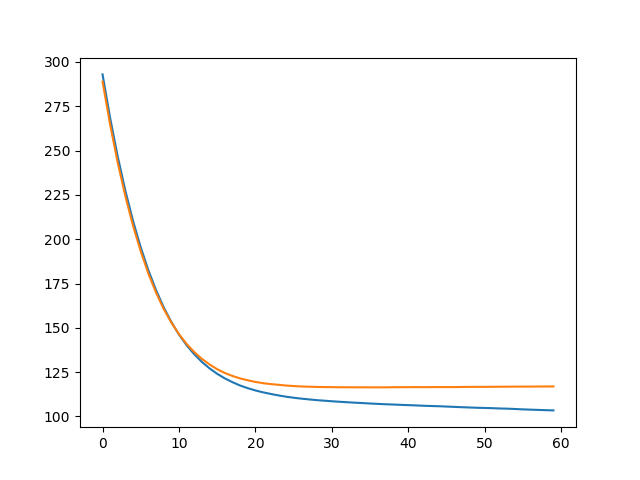

{'train': {'rmse': [103.432571]}, 'val': {'rmse': [116.936157]}}


In [117]:
df = pd.read_csv('store_sales_mod.csv')
#df = df[df.store_id==1]
df = pd.concat([df,pd.get_dummies(df.weekday,prefix='weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df.epoch_month,prefix='epoch_month')],axis=1)
df = pd.concat([df,pd.get_dummies(df.store_id,prefix='store_id')],axis=1)
df = df.sort_values('date')
features = list(set(df.columns)-{'store_name','date','sales','epoch_day','month','weekday',
                                'epoch_month','store_id'})#['weekday','epoch_month','store_id']
print(features)
#features = ['weekday','epoch_month']
target = 'sales'
trainX,valX,trainy,valy = train_test_split(df[features],df[target],test_size=0.2,shuffle=False)


# regressor = xgboost.XGBRegressor()
# regressor.fit(trainX[features],trainy)
# pred = regressor.predict(valX[features])
# print("RMSE is ",np.sqrt(mean_squared_error(valy,pred)))

# trainX,valX,trainy,valy = train_test_split(df[features],df[target],test_size=0.2)
dtrain = xgboost.DMatrix(data=trainX.as_matrix(),label=trainy.as_matrix())
dval = xgboost.DMatrix(data=valX.as_matrix(),label=valy.as_matrix())
param={ 'silent':1,
    'eta':0.1,'max_depth':10,
    'objective':'reg:linear'}
num_rounds = 60
#train_with_learning_curve(dtrain,dval,param,num_rounds)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.set_xlim(right=num_rounds)
evals = [(dtrain,'train'),(dval,'val')]
evals_result={}
train_error=[]
val_error=[]
bst = None
for i in range(num_rounds):
    bst = xgboost.train(param,dtrain,1,evals=evals,evals_result=evals_result,
                   verbose_eval=False)
    ptrain = bst.predict(dtrain,output_margin=True)
    pval = bst.predict(dval,output_margin=True)
    dtrain.set_base_margin(ptrain)
    dval.set_base_margin(pval)
    train_error.append(evals_result['train']['rmse'][0])
    val_error.append(evals_result['val']['rmse'][0])
    axis.clear()
    axis.plot(np.arange(len(train_error)),train_error)
    axis.plot(np.arange(len(val_error)),val_error)
    fig.canvas.draw()
print(evals_result)

In [94]:
trainX.head() ;trainy.head()

9000    440.86
9001    481.38
9002    480.15
9003    431.67
9004    441.55
Name: sales, dtype: float64

In [42]:
df = pd.read_csv('store_sales_mod.csv')

In [45]:
my_store = df[df.store_id==0]

In [47]:
my_store.head(10)

,store_name,date,sales,weekday,store_id,month
0,Store_1,2015-05-13,270.76,2,0,5
1,Store_1,2015-05-14,241.44,3,0,5
2,Store_1,2015-05-15,271.15,4,0,5
3,Store_1,2015-05-16,260.41,5,0,5
4,Store_1,2015-05-17,220.03,6,0,5
5,Store_1,2015-05-18,241.25,0,0,5
6,Store_1,2015-05-19,240.20,1,0,5
7,Store_1,2015-05-20,271.75,2,0,5
8,Store_1,2015-05-21,241.54,3,0,5
9,Store_1,2015-05-22,270.22,4,0,5


In [98]:
pd.get_dummies(df.weekday)

,0,1,2,3,4,5,6
9000,0,0,1,0,0,0,0
9001,0,0,0,1,0,0,0
9002,0,0,0,0,1,0,0
9003,0,0,0,0,0,1,0
9004,0,0,0,0,0,0,1
9005,1,0,0,0,0,0,0
9006,0,1,0,0,0,0,0
9007,0,0,1,0,0,0,0
9008,0,0,0,1,0,0,0
9009,0,0,0,0,1,0,0


In [80]:
[1,2,3]-[2]

TypeError: unsupported operand type(s) for -: 'list' and 'list'